<a href="https://colab.research.google.com/github/EdH66/CMAP-Analysis/blob/main/Drug_properties_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structure comparisons from data generated by CMAP_Query_Ranking.ipynb

* uses data from df_CMAP_MPO_RESULT.csv with NA filtered and NCS >1.5
* uses data from df_SELECT_DRUGS_RESULT.csv with NA filtered
* with package RDKit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge rdkit -y


✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [ ]:
# import drugs and filter
path_CMAP_MPO_RESULT = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_CMAP_MPO_RESULT.csv'
df_drugs = pd.read_csv(path_CMAP_MPO_RESULT)
# import selected drugs only
#path_selectdrugs = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_SELECT_DRUGS_RESULT.csv'
#df_selectdrugs = pd.read_csv(path_selectdrugs)




In [ ]:
#filter settings

# Filter the DataFrame based on 'NCS' < 1.5
# remove rows without Calculated_MPO
df_selectdrugs = df_drugs[df_drugs['NCS'] < 1.5].dropna(subset=['Calculated_MPO'])

original_count = df_drugs.shape[0]
filtered_count = df_selectdrugs.shape[0]
print(f"Number of rows in the original DataFrame: {original_count}")
print(f"Number of rows after filtering and removing NAs: {filtered_count}")



Number of rows in the original DataFrame: 1156
Number of rows after filtering and removing NAs: 276


In [ ]:
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np
import seaborn as sns

!pip install matplotlib
import matplotlib.pyplot as plt

Install condacolab and rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

In [ ]:
df_selectdrugs = df_selectdrugs[pd.notnull(df_selectdrugs['Smiles']) & df_selectdrugs['Smiles'].apply(lambda x: isinstance(x, str))]

# Now apply Chem.MolFromSmiles
df_selectdrugs['Molecules'] = df_selectdrugs['Smiles'].apply(Chem.MolFromSmiles)

# Generate Morgan fingerprints
df_selectdrugs['Fingerprint'] = df_selectdrugs['Molecules'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2))



#Calculate general solubility equation (GSE)

* Ali et al 2011 J. Chem. Inf. Model. 2012, 52, 2, 420–428

In [ ]:
df_selectdrugs


def predict_solubility_with_GSE(logP, tpsa):
    logS = -1.0377*logP - 0.0210*tpsa + 0.5134
    return logS

    # Apply the prediction function to each row in the DataFrame
df_selectdrugs['Predicted_logS'] = df_selectdrugs.apply(lambda row: predict_solubility_with_GSE(row['logp'], row['TSA']), axis=1)

# Display the DataFrame to verify the new column with predicted solubility values
print(df_selectdrugs[['pert_iname', 'NCS', 'Timepoint', 'Calculated_MPO','logp', 'Predicted_logS']])

df_selectdrugs.to_csv('/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_SELECT_MPO_LogS_RESULT.csv', index=False, na_rep='NA')


      pert_iname       NCS  Timepoint  Calculated_MPO  logp  Predicted_logS
0      letrozole -1.522099  12_wk_NCS        6.000000  2.66       -3.890972
1      trazodone -1.615299  12_wk_NCS        5.915214  2.36       -2.896952
2    tofacitinib -1.694498   8_wk_NCS        5.750000  1.54       -2.951768
3    moclobemide -1.547467  12_wk_NCS        5.750000  1.40       -1.812350
4    tofacitinib -1.657936   8_wk_NCS        5.750000  1.54       -2.951768
..           ...       ...        ...             ...   ...             ...
271  telotristat -1.693602  12_wk_NCS        1.785000  4.51       -7.152197
272    rifaximin -1.768196  16_wk_NCS        1.535000  6.16      -10.044812
273    rifaximin -1.040661  20_wk_NCS        1.535000  6.16      -10.044812
274   navitoclax -1.582513  12_wk_NCS        1.355000  8.83      -11.345051
275   rebastinib -0.954898  20_wk_NCS        1.250000  6.05       -8.348945

[276 rows x 6 columns]


#Plotting the results

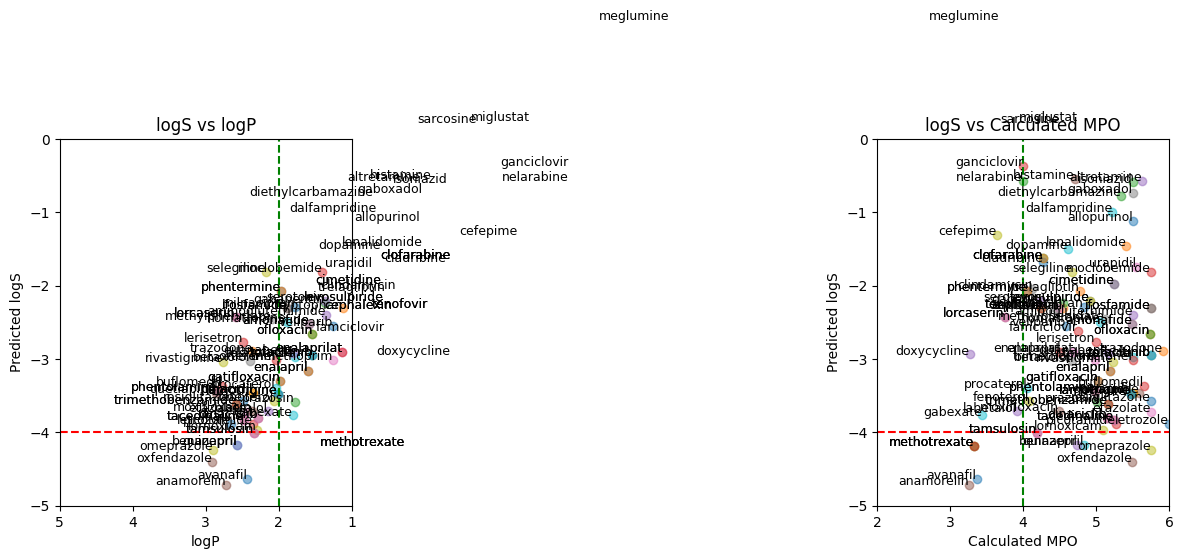

In [ ]:
import matplotlib.pyplot as plt

df_selectdrugs = df_selectdrugs[(df_selectdrugs['Calculated_MPO'] > 3) & (df_selectdrugs['logp'] < 3)]

# Plotting logS vs logP with labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for _, row in df_selectdrugs.iterrows():
    plt.scatter(row['logp'], row['Predicted_logS'], alpha=0.5)
    plt.text(row['logp'], row['Predicted_logS'], row['pert_iname'], fontsize=9, ha='right')
plt.title('logS vs logP')
plt.xlabel('logP')
plt.ylabel('Predicted logS')

# Draw horizontal and vertical lines for LogP
plt.axhline(y=-4, color='r', linestyle='--')
plt.axvline(x=2, color='g', linestyle='--')

plt.xlim([5, 1])
plt.ylim([-5, -0])

#
#
#
#

# Plotting logS vs Calculated MPO with labels
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for _, row in df_selectdrugs.iterrows():
    plt.scatter(row['Calculated_MPO'], row['Predicted_logS'], alpha=0.5)
    plt.text(row['Calculated_MPO'], row['Predicted_logS'], row['pert_iname'], fontsize=9, ha='right')
plt.title('logS vs Calculated MPO')
plt.xlabel('Calculated MPO')
plt.ylabel('Predicted logS')

# Plot adjustments and lines
#
#
#

# Draw horizontal and vertical lines at example values
plt.axhline(y=-4, color='r', linestyle='--')
plt.axvline(x=4, color='g', linestyle='--')

#Aqueous Soluble Compounds (logS > -1 to <-4):
#CNS (logp >2 and <4):

# Adjusting axes limits if necessary
plt.xlim([2, 6])
plt.ylim([-5, -0])


plt.tight_layout()
plt.show()

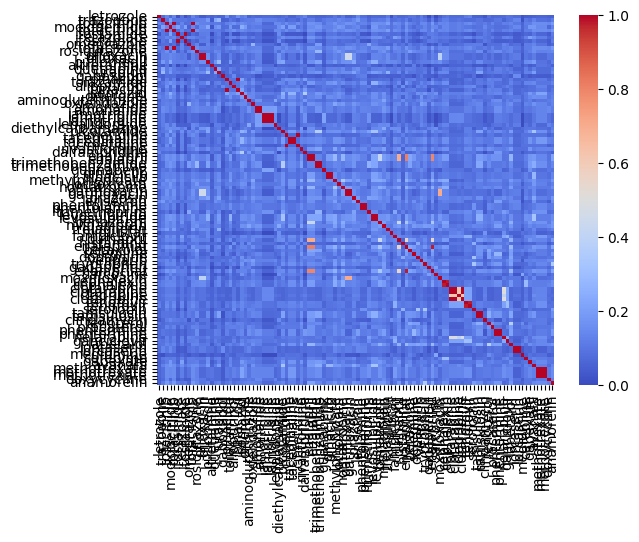

In [ ]:
# Compute and plot similarity matrix
n = len(df_selectdrugs)
similarity_matrix = np.zeros((n, n))
pert_iname = df_selectdrugs['pert_iname'].values
pert_iname = df_selectdrugs['pert_iname'].tolist()

for i in range(n):
    for j in range(i, n):
        similarity = DataStructs.FingerprintSimilarity(df_selectdrugs.iloc[i]['Fingerprint'], df_selectdrugs.iloc[j]['Fingerprint'])
        similarity_matrix[i, j] = similarity_matrix[j, i] = similarity

# Plotting the similarity matrix with drug names as labels
sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm', xticklabels=pert_iname, yticklabels=pert_iname)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()